In [96]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [97]:
df = pd.read_csv("clean_data.csv")
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
3,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [98]:
X = df.drop(['csMPa'],axis=1)
X.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90
3,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28


In [99]:
y =df['csMPa']
y.head()

0    79.99
1    61.89
2    47.03
3    36.45
4    45.85
Name: csMPa, dtype: float64

In [100]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(len(X_train),len(X_test))

756 190


In [101]:
m = MinMaxScaler()
X_train_scaled=m.fit_transform(X_train)
X_test_scaled = m.transform(X_test)

In [102]:
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7
0,0.252283,0.000000,0.5020,0.299760,0.270186,0.601163,0.776719,0.109244
1,0.769406,0.492487,0.0000,0.513189,0.344720,0.243895,0.285750,0.016807
2,0.341096,0.000000,0.5915,0.533173,0.198758,0.661047,0.410687,0.016807
3,0.563927,0.000000,0.0000,0.561151,0.000000,0.715116,0.531862,0.226891
4,0.863014,0.000000,0.0000,0.561151,0.000000,0.393023,0.296538,0.226891
...,...,...,...,...,...,...,...,...
751,0.120548,0.510295,0.0000,0.571543,0.282609,0.716279,0.257652,0.226891
752,0.130137,0.414580,0.5800,0.425260,0.465839,0.441860,0.316106,0.226891
753,0.502283,0.414580,0.0000,0.513189,0.248447,0.436047,0.288510,0.226891
754,0.621005,0.526433,0.0000,0.386091,0.313665,0.363663,0.408179,0.226891


In [103]:
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(m, f)

In [104]:
models_and_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'model__fit_intercept': [True, False],
            'model__positive': [True, False] if hasattr(LinearRegression(), 'positive') else [True]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0],
            'model__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
        }
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        }
    },
    'SGDRegressor': {
        'model': SGDRegressor(max_iter=1000, tol=1e-3),
        'params': {
            'model__alpha': [0.0001, 0.001, 0.01],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__learning_rate': ['invscaling', 'constant', 'adaptive']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10],
            'model__bootstrap': [True, False]
        }
    }
}

In [105]:
best_models = {}

for name, config in models_and_params.items():
    pipe = Pipeline([
        ('model', config['model'])
    ])
    grid = GridSearchCV(pipe, config['params'], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_models[name] = grid
    print(f"Best {name}: {grid.best_score_:.4f} with params: {grid.best_params_}")


Best LinearRegression: 0.7412 with params: {'model__fit_intercept': False, 'model__positive': False}
Best Ridge: 0.7403 with params: {'model__alpha': 0.01, 'model__solver': 'svd'}
Best Lasso: 0.7411 with params: {'model__alpha': 0.01}
Best ElasticNet: 0.7391 with params: {'model__alpha': 0.01, 'model__l1_ratio': 0.9}
Best SGDRegressor: 0.7399 with params: {'model__alpha': 0.001, 'model__learning_rate': 'adaptive', 'model__penalty': 'l1'}
Best DecisionTree: 0.8103 with params: {'model__max_depth': None, 'model__min_samples_split': 10}
Best RandomForest: 0.8922 with params: {'model__bootstrap': True, 'model__max_depth': None, 'model__n_estimators': 200}


In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error
value =[['model_name','MAE','MSE','R2','RMSE']]
for model in best_models.keys():
    y_pred = best_models[model].predict(X_test_scaled)
    mse=mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    r = r2_score(y_test,y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)
    value.append([model,mae,mse,r,rmse])
value =pd.DataFrame(value[1:],columns=value[0])
value


,model_name,MAE,MSE,R2,RMSE
0,LinearRegression,6.531665,72.314588,0.741003,8.503798
1,Ridge,6.523567,72.154955,0.741575,8.494407
2,Lasso,6.502027,71.722824,0.743123,8.468933
3,ElasticNet,6.452809,70.801852,0.746421,8.414384
4,SGDRegressor,6.449349,70.885602,0.746121,8.419359
5,DecisionTree,5.177338,51.815541,0.814421,7.198301
6,RandomForest,3.879486,29.278720,0.895137,5.410981


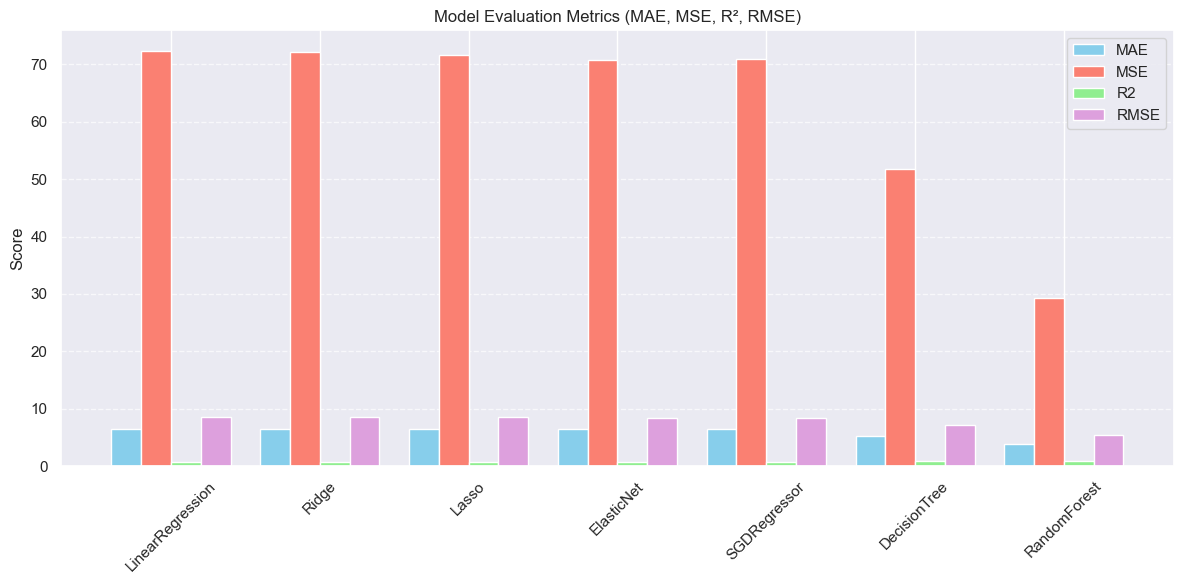

In [109]:
# Plot settings
metrics = ['MAE', 'MSE', 'R2', 'RMSE']
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']
x = np.arange(len(value['model_name']))  # label locations
width = 0.2  # width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, value[metric], width, label=metric, color=colors[i])

# X-axis labels and ticks
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(value['model_name'], rotation=45)
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics (MAE, MSE, R², RMSE)')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [112]:
import pickle
with open('best_model.pkl','wb') as f :
    pickle.dump(best_models['RandomForest'],f)